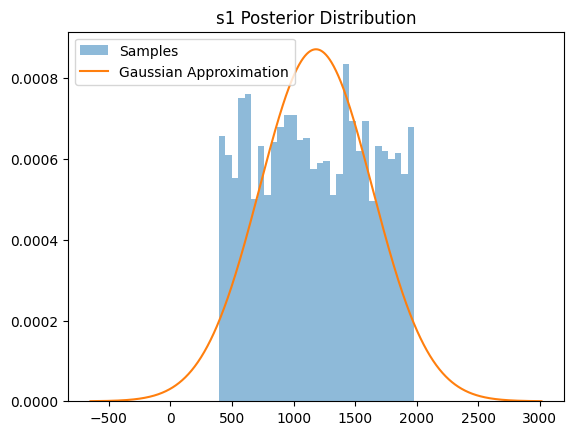

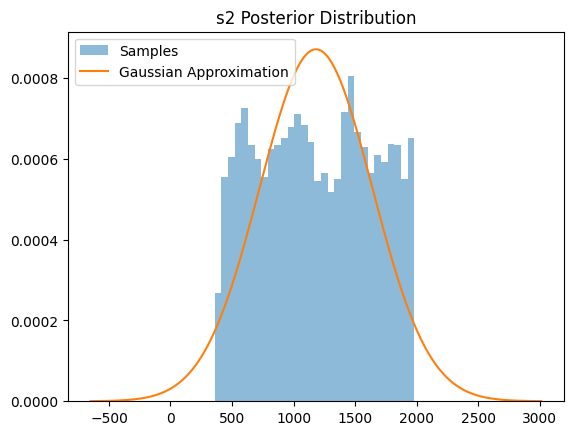

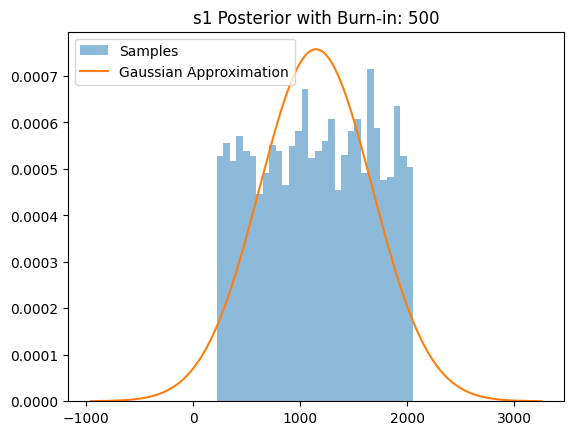

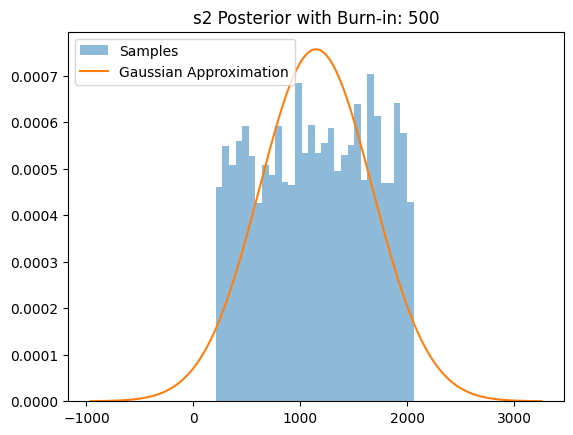

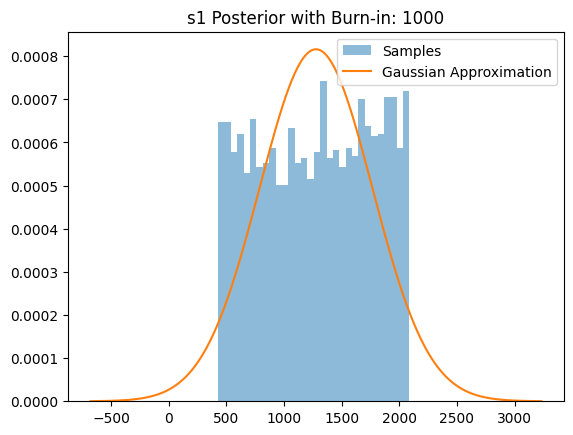

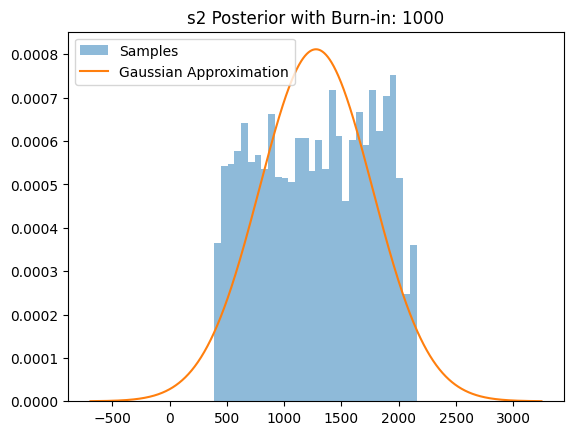

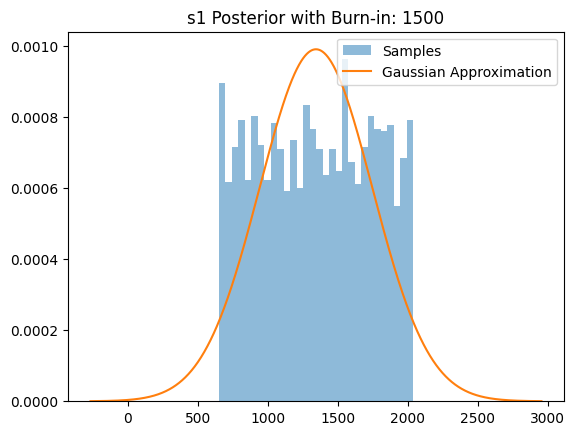

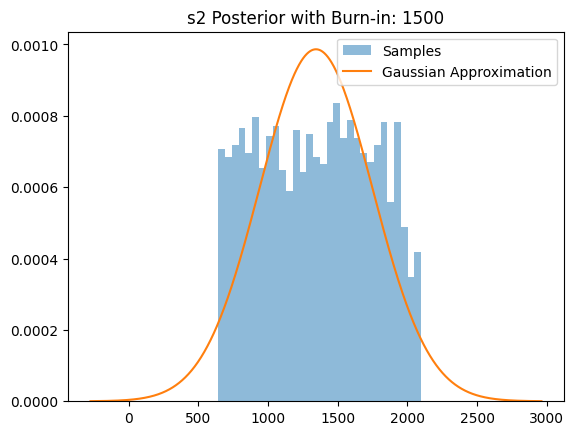

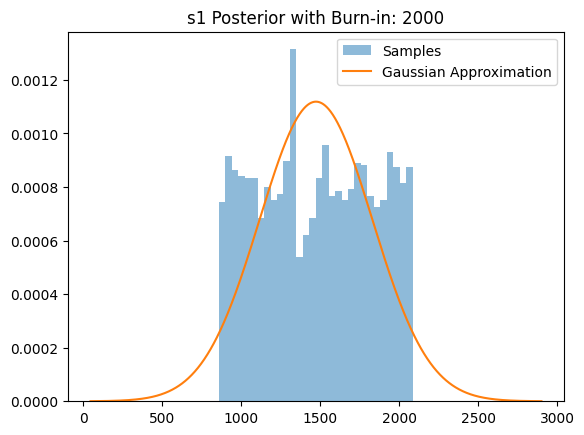

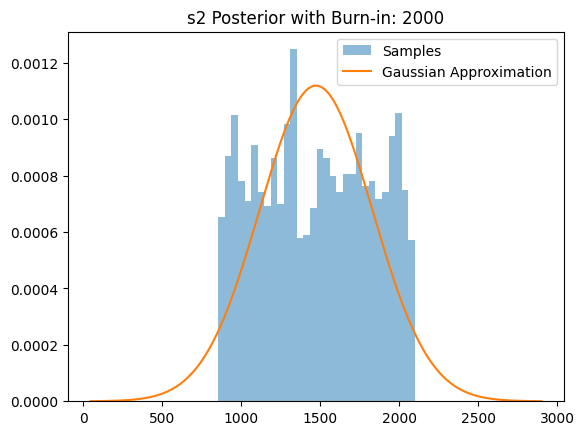

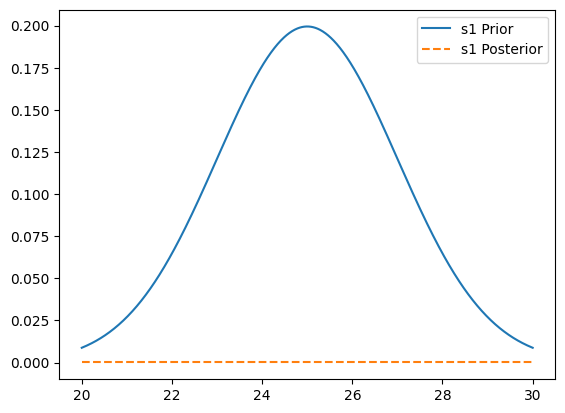

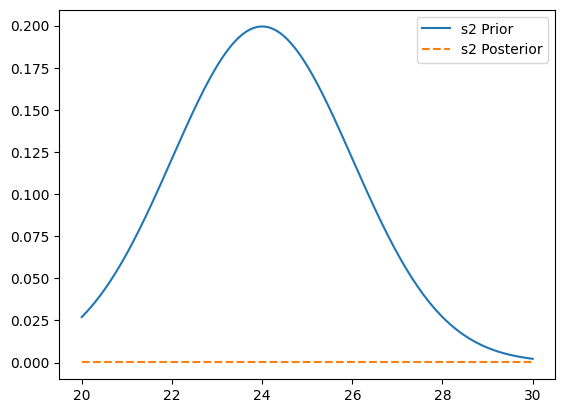

In [2]:
import numpy as np
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import time

class TrueSkillModel:
    def __init__(self, beta=0.5, s1_prior_mean=25, s1_prior_std=2, s2_prior_mean=24, s2_prior_std=2):
        self.beta = beta
        self.s1_prior_mean = s1_prior_mean
        self.s1_prior_std = s1_prior_std
        self.s2_prior_mean = s2_prior_mean
        self.s2_prior_std = s2_prior_std

    def gibbs_sampler(self, y, num_samples, burn_in=1000):
        s1_samples = np.zeros(num_samples)
        s2_samples = np.zeros(num_samples)
        
        # Initialize s1 and s2
        s1 = self.s1_prior_mean
        s2 = self.s2_prior_mean
        
        for i in range(num_samples):
            # Sample t given s1, s2, and y
            t = self.sample_t_given_y_s1_s2(y, s1, s2)
            
            # Sample s1 and s2 given t
            s1 = np.random.normal(t + s2, self.beta)
            s2 = np.random.normal(t + s1, self.beta)
            
            s1_samples[i] = s1
            s2_samples[i] = s2
        
        return s1_samples[burn_in:], s2_samples[burn_in:]
    
    def sample_t_given_y_s1_s2(self, y, s1, s2):
        a, b = (-np.inf, 0) if y == -1 else (0, np.inf)
        mean = s1 - s2
        return truncnorm.rvs(a, b, loc=mean, scale=self.beta)

    def gaussian_approximation(self, samples):
        mean = np.mean(samples)
        std = np.std(samples)
        return mean, std

    def plot_histogram_and_gaussian(self, samples, title=""):
        mean, std = self.gaussian_approximation(samples)
        plt.hist(samples, density=True, bins=30, alpha=0.5, label="Samples")
        x = np.linspace(mean - 4*std, mean + 4*std, 1000)
        plt.plot(x, norm.pdf(x, mean, std), label="Gaussian Approximation")
        plt.title(title)
        plt.legend()
        plt.show()

    def experiment_with_burnin(self, y, num_samples, burn_in_values):
        for burn_in in burn_in_values:
            s1_samples, s2_samples = self.gibbs_sampler(y, num_samples, burn_in)
            self.plot_histogram_and_gaussian(s1_samples, title=f"s1 Posterior with Burn-in: {burn_in}")
            self.plot_histogram_and_gaussian(s2_samples, title=f"s2 Posterior with Burn-in: {burn_in}")

    def compare_prior_posterior(self, y, num_samples, burn_in):
        s1_samples, s2_samples = self.gibbs_sampler(y, num_samples, burn_in)
        s1_post_mean, s1_post_std = self.gaussian_approximation(s1_samples)
        s2_post_mean, s2_post_std = self.gaussian_approximation(s2_samples)

        x = np.linspace(20, 30, 1000)
        plt.plot(x, norm.pdf(x, self.s1_prior_mean, self.s1_prior_std), label="s1 Prior")
        plt.plot(x, norm.pdf(x, s1_post_mean, s1_post_std), '--', label="s1 Posterior")
        plt.legend()
        plt.show()

        plt.plot(x, norm.pdf(x, self.s2_prior_mean, self.s2_prior_std), label="s2 Prior")
        plt.plot(x, norm.pdf(x, s2_post_mean, s2_post_std), '--', label="s2 Posterior")
        plt.legend()
        plt.show()


model = TrueSkillModel()

# Some usage examples
# 1. Gibbs sampling
y = 1
num_samples = 5000
burn_in = 1000
s1_samples, s2_samples = model.gibbs_sampler(y, num_samples, burn_in)
model.plot_histogram_and_gaussian(s1_samples, title="s1 Posterior Distribution")
model.plot_histogram_and_gaussian(s2_samples, title="s2 Posterior Distribution")

# 2. Experiment with different burn-ins
burn_in_values = [500, 1000, 1500, 2000]
model.experiment_with_burnin(y, num_samples, burn_in_values)

# 3. Compare prior and posterior distributions
model.compare_prior_posterior(y, num_samples, burn_in)
